In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

from matplotlib import pyplot as plt
import decoupler as dc

In [2]:
from sklearn.neighbors import BallTree

In [3]:
import geopandas as gpd

In [4]:
import muon as mu

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# slide names and x, y offsets
slides = {'A1':[3.5, 18],
          'B1':[3, 10.5],
          'C1':[1, 13.5],
          }

In [6]:
## load slide
slide = "C1"
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085
slide_path = f"../data/sma/{exp}/{exp}_{slide}/output_data"
rna_path = slide_path + f"/{exp}_{slide}_RNA/outs/"

In [7]:
rna = sq.read.visium(rna_path, counts_file="filtered_feature_bc_matrix.h5")
rna.obs[['x', 'y']] = rna.obsm['spatial']

msi_raw = pd.read_csv(slide_path + f"/{exp}_{slide}_MSI/{exp}_{slide}.Visium.FMP.220826_smamsi.csv")


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [8]:
# set x and y columns as index, concat with _ as separator
msi_raw.index = msi_raw[['x', 'y']].astype(str).agg('_'.join, axis=1)

In [9]:
# Only for mouse
lesion = pd.read_csv(rna_path + "/lesion.csv").set_index("Barcode")
region = pd.read_csv(rna_path +  "/region.csv").set_index("Barcode")
rna.obs = rna.obs.join(lesion)
rna.obs = rna.obs.join(region)

MSI

In [10]:
msi = msi_raw.copy().drop(['x', 'y'], axis=1)
msi = sc.AnnData(X=msi.values,
                 obs=pd.DataFrame(index=msi.index),
                 var=pd.DataFrame(index=msi.columns))

In [11]:
# copy raw intensities
msi.layers['raw'] = msi.X.copy()

# normalize and cluster (as they do)
sc.pp.normalize_total(msi, target_sum=1e4)
sc.pp.log1p(msi)
sc.pp.scale(msi)
sc.pp.pca(msi)
sc.pp.neighbors(msi, n_neighbors=10, n_pcs=20)
sc.tl.leiden(msi, resolution=0.00001)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [12]:
# get positions; NOTE: x and y are mirrored in the msi data
positions = msi_raw[['y', 'x']].values.copy()

# estimate scaling factor
sfactor = rna.uns['spatial'][f"{exp}_{slide}"]['scalefactors']['fiducial_diameter_fullres']
sfactor

607.8085000000001

In [13]:
# inverse y
positions[:, 0] = (positions[:, 0].max() - positions[:, 0])
# offset
x_offset = slides[slide][0]
y_offset = slides[slide][1]

positions[:, 0] = positions[:, 0] + x_offset
positions[:, 1] = positions[:, 1] + y_offset

msi.obs[['array_row', 'array_col']] = positions

# scale
positions = positions * sfactor * 0.95

In [14]:
msi.uns = rna.uns.copy()

In [15]:
msi.obsm['spatial'] = positions
msi.obs[['x', 'y']] = positions

In [16]:
# remove cells that are not in the tissue
msi = msi[msi.obs['leiden'] != '1', :]

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


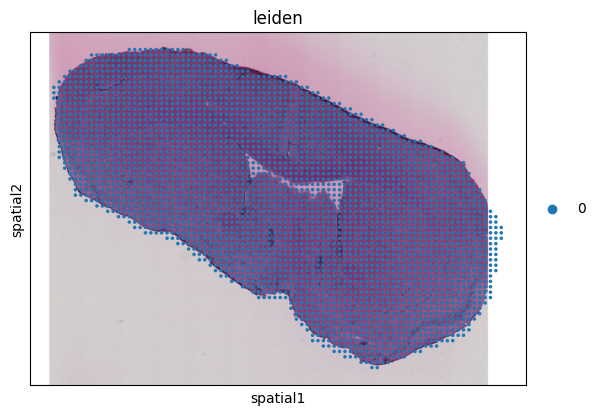

In [17]:
sc.pl.spatial(msi, color="leiden")

In [18]:
# msi.obs.index = msi.obsm['spatial']

In [19]:
mdata = mu.MuData({'rna':rna, 'msi':msi})

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


In [20]:
# swap back to raw intensities
mdata.mod['msi'].X = mdata.mod['msi'].layers['raw'].copy()

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


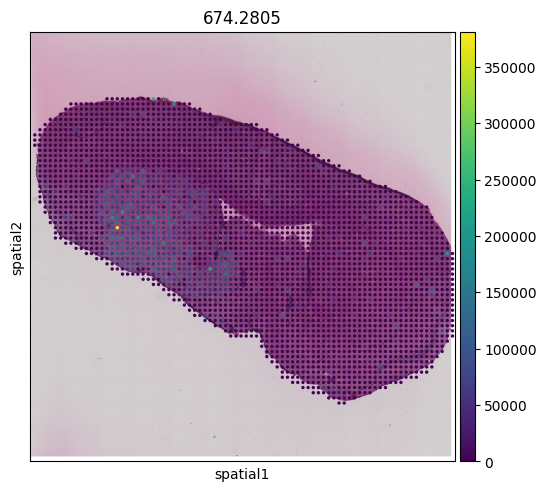

In [21]:
sq.pl.spatial_scatter(mdata.mod['msi'], color=['674.2805']) # plot dopamine

## QC

In [22]:
rna.var_names_make_unique()
msi.var_names_make_unique()

### Process RNA

In [23]:
sc.pp.filter_cells(mdata.mod['rna'], min_genes=200)
sc.pp.filter_cells(mdata.mod['rna'], min_counts=100)
sc.pp.filter_genes(mdata.mod['rna'], min_cells=3)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


### Process metabolites

In [24]:
# change type to float
msi.var['mz'] = msi.var.index.astype(float)
# round to 2 decimals
msi.var['mz'] = [round(x, 2) for x in msi.var['mz']]

In [25]:
msi.var['max_intensity'] = msi.X.sum(axis=0)

In [26]:
msi.var['mz_raw'] = msi.var.index.astype(str)

In [27]:
molecule_weights = {
    'GABA': 371.17556, # 371.18,
    'GABA-H2O': 353.16488, # 353.16 (rounding as in paper)
    'Taurine': 393.12718, # 393.13,
    'Serotonin': 444.20746, # 444.21,
    'Histidine': 423.18201, # NOTE: 423.18 Not in supp table
    '3-MT': 435.20706, # 435.21,
    'Dopamine (single)': 421.19146,
    'Dopamine (double)': 674.28041, #  674.28,
    'DOPAC': 689.24381, # 698.24
    'NE (Norepinephrine)':690.27435, #  690.28,
    'Tocopherol': 698.49272 # 698.49
}

In [28]:
# round to 2 decimals
molecule_weights = {k: round(v, 2) for k, v in molecule_weights.items()}

In [29]:
[mol in msi.var['mz'].values for mol in list(molecule_weights.values())]

[True, False, True, True, True, True, True, True, False, True, True]

In [30]:
putative_molecules = pd.read_csv("../data/sma/putative_peaks.csv")
putative_molecules = putative_molecules.set_index('metabolite')
# pivot to long
putative_molecules = putative_molecules.stack().reset_index()
putative_molecules.rename(columns={'level_1':'peak', 0:'mz'}, inplace=True)
putative_molecules['metabolite'] = putative_molecules['metabolite'] + " (" + putative_molecules['peak'] + ")"

In [31]:
# round to mz to two decimals
putative_molecules['raw_mz'] = putative_molecules['mz']
putative_molecules['mz'] = [round(x, 2) for x in putative_molecules['mz']]
# set as index, keep previous index as column
putative_molecules = putative_molecules.set_index('metabolite', drop=False)

In [32]:
# filter out molecules that are already in the data
putative_molecules = putative_molecules[~putative_molecules['mz'].isin(molecule_weights.values())]

In [33]:
molecules = pd.DataFrame.from_dict(molecule_weights, orient='index', columns=['mz'])
# concat
molecules = pd.concat([molecules, putative_molecules])[['mz']].to_dict()['mz']

In [34]:
msi.var['annotated'] = msi.var['mz'].map({v: k for k, v in molecules.items()})
msi.var['annotated'] = msi.var['annotated'].astype('category')
# if Name is NaN, then use mz_raw
msi.var['name'] = msi.var.apply(lambda x: x['mz_raw'] if pd.isnull(x['annotated']) else x['annotated'], axis=1)
msi.var['name'] = msi.var['name'].astype('str')

In [35]:
msi.var.set_index('name', inplace=True)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


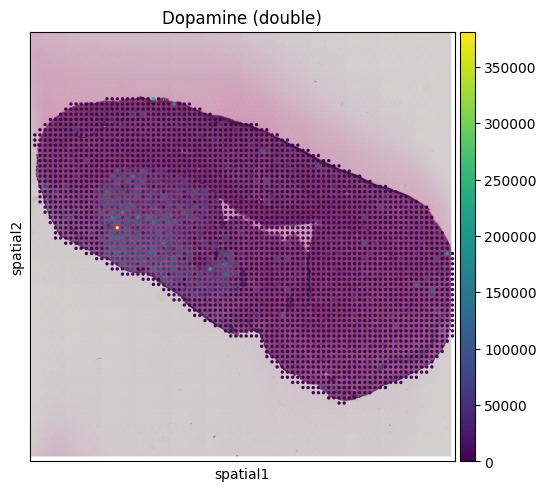

In [36]:
sq.pl.spatial_scatter(msi, color=["Dopamine (double)"])

In [37]:
# drop duplicates
msi = msi[:, ~msi.var.index.duplicated()]

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [38]:
sc.pp.filter_cells(msi, min_counts=200)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(array([   4.,   22.,  159.,  783., 1009.,  642.,  303.,   80.,   31.,
           7.]),
 array([1.21269379e+08, 1.38513479e+08, 1.55757578e+08, 1.73001678e+08,
        1.90245778e+08, 2.07489878e+08, 2.24733978e+08, 2.41978077e+08,
        2.59222177e+08, 2.76466277e+08, 2.93710377e+08]),
 <BarContainer object of 10 artists>)

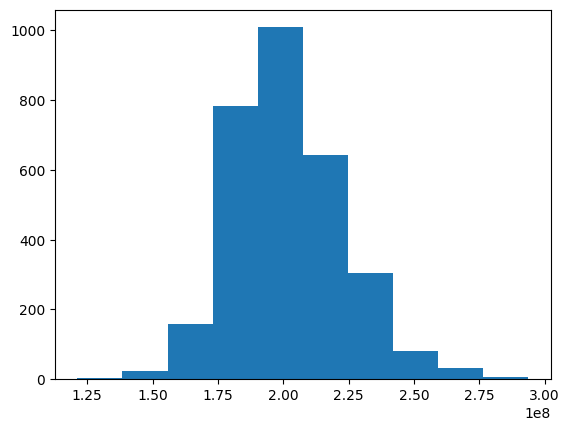

In [39]:
plt.hist(msi.X.sum(axis=1))

In [40]:
mdata.mod['msi'] = msi

In [41]:
mdata.mod['msi'].var.index = mdata.mod['msi'].var.index.astype(str)

Normalize

In [42]:
mdata.mod['rna'].layers['counts'] = mdata.mod['rna'].X.copy()
sc.pp.normalize_total(mdata.mod['rna'], target_sum=1e4)
sc.pp.log1p(mdata.mod['rna'])

In [43]:
mdata.mod['msi'].X = mdata.mod['msi'].layers['raw'].copy()

In [44]:
sc.pp.normalize_total(mdata.mod['msi'], target_sum=1)
mu.prot.pp.clr(mdata.mod['msi'])

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


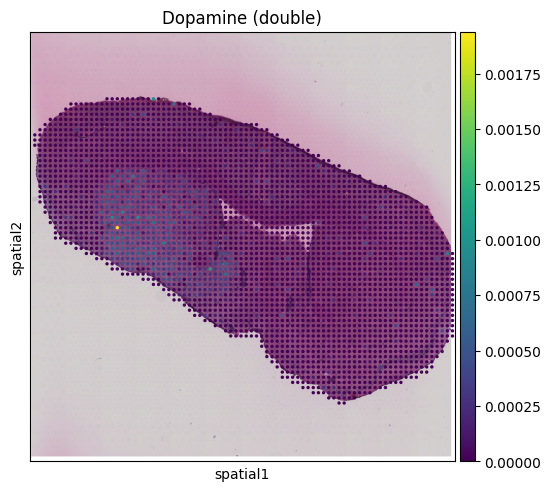

In [45]:
sq.pl.spatial_scatter(msi, color=["Dopamine (double)"])

Transfer annotations

In [46]:
# coordinates to points
rna_points = gpd.points_from_xy(rna.obs['x'], rna.obs['y'].values)
msi_points = gpd.points_from_xy(msi.obs['x'], msi.obs['y'].values)

In [47]:
original_gdf = gpd.GeoDataFrame(rna.obs[['region', 'lesion']], geometry=rna_points)
target_gdf = gpd.GeoDataFrame(msi.obs, geometry=msi_points)

In [48]:
rna.obs

,in_tissue,array_row,array_col,x,y,lesion,region,n_genes,n_counts
AAACAAGTATCTCCCA-1,1,50,102,34082,29561,lesioned,striatum,2359,6011.0
AAACATTTCCCGGATT-1,1,61,97,32633,35100,lesioned,striatum,2911,7265.0
AAACCCGAACGAAATC-1,1,45,115,37845,27044,lesioned,striatum,1815,3944.0
AAACCGGAAATGTTAA-1,1,54,124,40449,31577,lesioned,striatum,1386,2471.0
AAACCGGGTAGGTACC-1,1,42,28,12665,25526,intact,striatum,3133,10917.0
...,...,...,...,...,...,...,...,...,...
TTGTTAGCAAATTCGA-1,1,22,42,16720,15455,intact,not_striatum,1110,2363.0
TTGTTCAGTGTGCTAC-1,1,24,64,23087,16464,intact,not_striatum,2754,7231.0
TTGTTCTAGATACGCT-1,1,21,3,5432,14948,intact,not_striatum,2195,5127.0
TTGTTGTGTGTCAAGA-1,1,31,77,26849,19990,lesioned,not_striatum,1468,2944.0


In [49]:
# target_gdf to orginary df, without geometry
target_df = pd.DataFrame(target_gdf.sjoin_nearest(original_gdf, how='left').drop(columns='geometry'))

In [50]:
# annotations to msi
mdata.mod['msi'].obs = target_df

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_ma

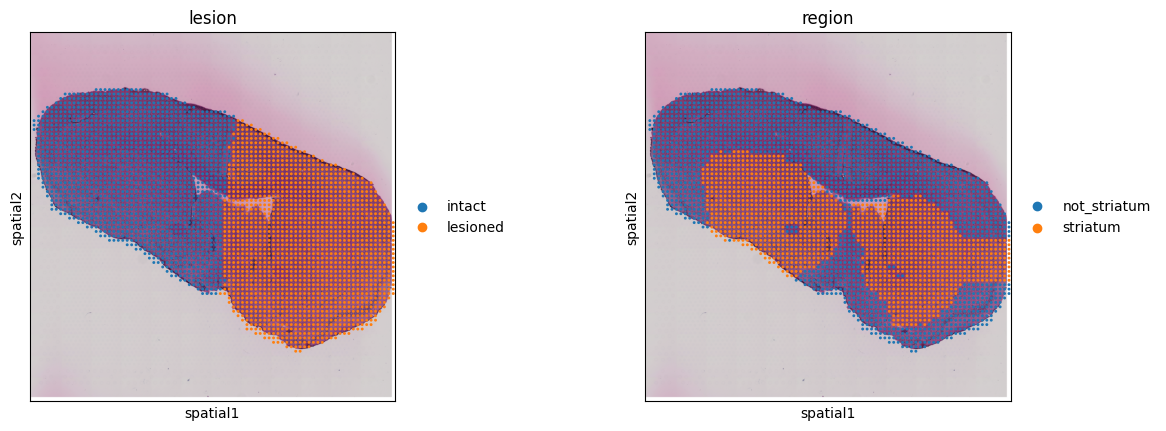

In [51]:
sq.pl.spatial_scatter(mdata.mod['msi'], color=['lesion', 'region'])

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_ma

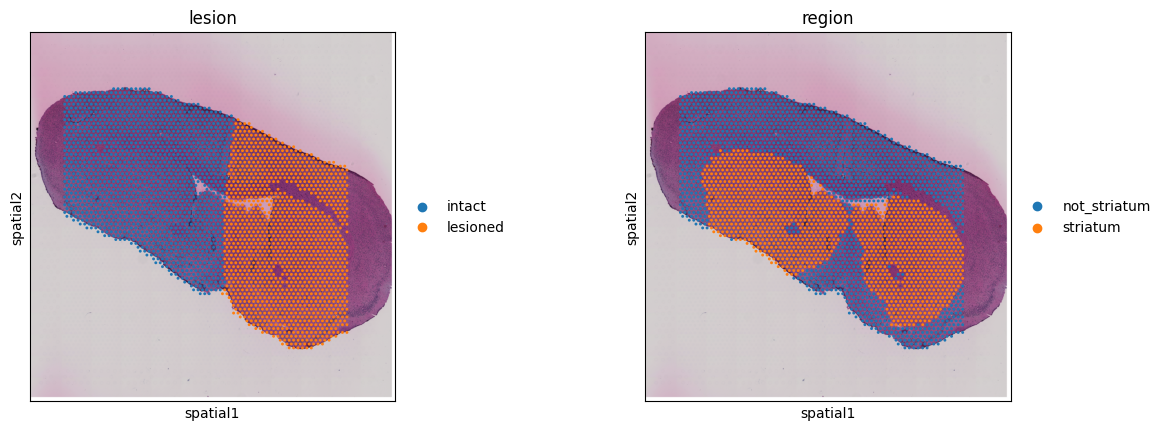

In [52]:
sq.pl.spatial_scatter(mdata.mod['rna'], color=['lesion', 'region'])

Write modalities as they are

In [53]:
mdata = mu.MuData(mdata.mod)
mdata.write_h5mu(os.path.join(slide_path, "sma.h5mu"))

### Match observations

MSI matched

In [54]:
rna_pos = rna.obsm['spatial'].copy()
msi_pos = msi.obsm['spatial'].copy()

In [55]:
# train kdtree on rna positions
tree = BallTree(rna_pos)

# find nearest neighbor for each msi spot
dists, neighbors = tree.query(msi_pos, k=1)
# flatten
dists, neighbors = dists.flatten(), neighbors.flatten()

# calculate proximities
proximity = 1 - (dists / np.max(dists))


(array([  14.,   17.,   20.,   25.,   58.,   48.,   73.,   72.,   85.,
        2628.]),
 array([0.        , 0.09997709, 0.19995419, 0.29993128, 0.39990838,
        0.49988547, 0.59986257, 0.69983966, 0.79981675, 0.89979385,
        0.99977094]),
 <BarContainer object of 10 artists>)

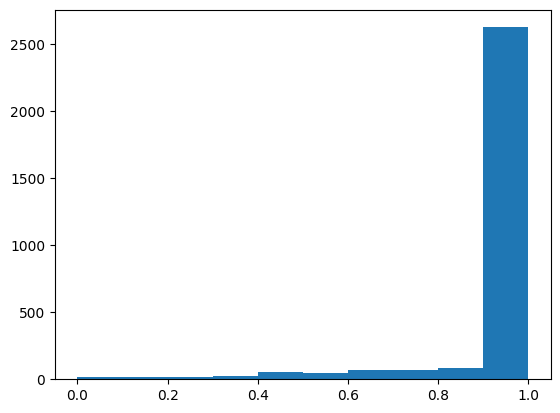

In [56]:
# get barcode of nearest neighbor
msi.obs['knn_barcode'] = rna.obs.iloc[neighbors, :].index
# get proximity of nearest neighbor
msi.obs['knn_proximity'] = proximity

# histrogram of distances
from matplotlib import pyplot as plt
plt.hist(proximity, bins=10)


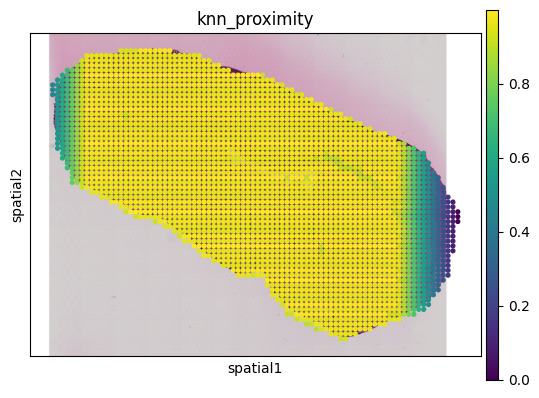

In [57]:
sc.pl.spatial(msi, color="knn_proximity", spot_size=sfactor)

In [58]:
# those with proximity of > 0.9 are considered to have a match
msk = msi.obs['knn_proximity'] > 0.9
matched = msi[msk, :].copy()
not_matched = msi[~msk, :].copy()

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [59]:
# those that barcodes are missing (not found as NN)
missing = rna[~rna.obs.index.isin(matched.obs['knn_barcode']), :].copy()
del missing.var
X = np.zeros((missing.shape[0], matched.shape[1]))
missing = sc.AnnData(X=X, obs=missing.obs.copy(), var=matched.var.copy())

In [60]:
matched = dc.get_pseudobulk(matched,
                            sample_col='knn_barcode',
                            groups_col=None, 
                            skip_checks=True, 
                            mode='mean', 
                            min_cells=0,
                            min_counts=0,
                            layer='raw'
                            )

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/decoupler/utils_anndata.py:163: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cols = obs.groupby(sample_col).apply(lambda x: x.apply(lambda y: len(y.unique()) == 1)).all(0)
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [61]:
matched.obs = pd.DataFrame(index=matched.obs['knn_barcode'])
matched.obs = matched.obs.join(rna.obs)

In [62]:
# merge anndata
msi_matched = sc.concat([matched, not_matched, missing], axis=0, label='modality', join='outer')
msi_matched.obsm['spatial'] = msi_matched.obs[['x', 'y']].values

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):


RNA Matched

In [63]:
X = np.zeros([not_matched.shape[0], rna.shape[1]])

In [64]:
rna_missing = sc.AnnData(X=X, obs=not_matched.obs, var=rna.var)

In [65]:
rna_matched = sc.concat([rna, rna_missing], axis=0, label='modality', join='outer')
rna_matched.obsm['spatial'] = rna_matched.obs[['x', 'y']].values.copy()

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):


In [66]:
### TODO: Standardize this function, and replace mean with weighted mean by proximity

Write matched coordinate systems

In [67]:
mdata_matched = mu.MuData({'rna': rna_matched, 'msi': msi_matched})

In [68]:
mdata_matched.mod['msi'].var.index = mdata_matched.mod['msi'].var.index.astype(str)

In [69]:
mdata_matched.write_h5mu(os.path.join(slide_path, "sma_matched.h5mu"))